In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoNormal
from pyro.infer import Predictive

from utils import *

First we define our 2 player model in Pyro. 

In [14]:
def Model2Player(game_info, obs=None):
    """
    Inputs: 
        game_info: A dictionary containing relevant information about the games played.
        obs: A 1D tensor of observed data. The length should be equal to the number of games played.
             Represents the outcome of a game in the eyes of coach 1, i.e. coach 1 wins: obs = 1, coach 2 wins: obs = -1.

    Output: A 1D tensor of the same length as the input tensor. Represents a sample from difference in performance between the two coaches.
    """
    
    # define hyperparameters
    hyper_sigma = 1/8
    
    coach1_mu_skill = 0
    coach1_sigma_skill = 1

    coach2_mu_skill = 0
    coach2_sigma_skill = 1

    # initialize the skill of the coaches
    coach1_skill = pyro.sample("coach1_skill", dist.Normal(coach1_mu_skill, coach1_sigma_skill))
    coach2_skill = pyro.sample("coach2_skill", dist.Normal(coach2_mu_skill, coach2_sigma_skill))
    
    # define plate for the number of games played
    with pyro.plate('matches', obs.shape[0]):   

        # sample the performance of each coach
        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skill, hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skill, hyper_sigma))

        # calculate the difference in performance
        perf_diff = coach1_perf - coach2_perf
    
        # sample the outcome of the game
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y

First we want to check if the model behaves as expected, so we test it out with some dummy data. First we make dummy data where player 1 always wins. 

In [15]:
num_games = 100
game_info = {}
obs = torch.ones(num_games)

guide = AutoNormal(Model2Player)
losses = run_inference(Model2Player, guide, game_info, obs)

  0%|          | 0/2000 [00:00<?, ?it/s]

Loss = -21.387632: 100%|██████████| 2000/2000 [00:18<00:00, 105.37it/s]


Generate samples from the distribution of each players skill.

In [16]:
predictive = Predictive(Model2Player, guide=guide, num_samples=2000, return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(game_info, obs)

We plot the samples from the posterior distribution of each players skill.

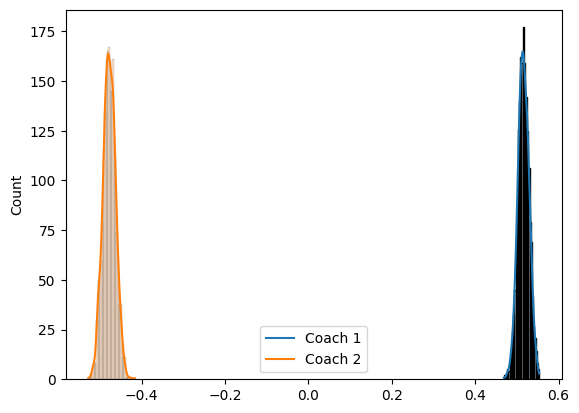

In [17]:
import seaborn as sns

#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["Coach 1", "Coach 2"])
plt.show()

It is clear to see after winning 100 games in a row, then the model has updated the players skills accordingly. Player 1 now has a higher skill than player 2.

For the second dummy data set we set each match to be a draw.

In [18]:
obs = torch.zeros(num_games)

guide = AutoNormal(Model2Player)
losses = run_inference(Model2Player, guide, game_info, obs)

Loss = -24.342998: 100%|██████████| 2000/2000 [00:18<00:00, 109.85it/s]


In [19]:
predictive = Predictive(Model2Player, guide=guide, num_samples=2000, return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(game_info, obs)

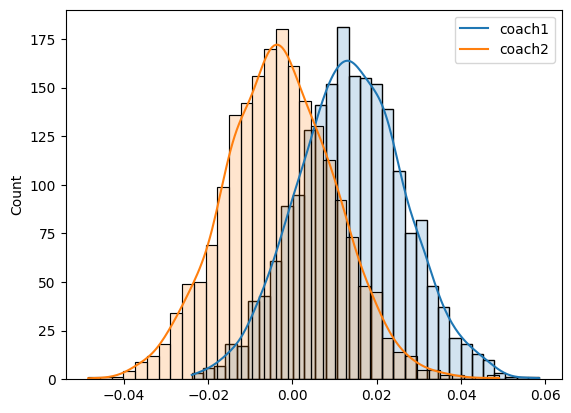

In [20]:
#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()

One important thing to note from these posteriors, is that even though the players should be completely equal as 100 games have resulted in a draw. However, the distributions indicate that coach 1 is slightly better than coach 2. Since the output of the model is continuous, then you have to be careful when interpreting the results. This will be important later when discussing the draw margin mentioned in the report.